# Where should a drinks company run promotions?

## 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

plt.style.use("seaborn")

pd.set_option("display.max_rows", 100)

## 1. Reading dataset

In [2]:
alcohol_sales_df = pd.read_csv("data/russian_alcohol_consumption.csv")

display(alcohol_sales_df.head())

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


### a. Dataset shape

In [3]:
alcohol_sales_df.shape

(1615, 7)

### b. Unique value count of columns

In [4]:
def unique_value_count(df: pd.DataFrame):
    df_nunique = df.nunique().reset_index()
    df_nunique['dtype'] = df.dtypes.reset_index().loc[:, 0]
    df_nunique.columns = ['column', 'nunique', 'dtype']
    
    display(df_nunique)

In [5]:
unique_value_count(df=alcohol_sales_df)

,column,nunique,dtype
0,year,19,int64
1,region,85,object
2,wine,210,float64
3,beer,796,float64
4,vodka,313,float64
5,champagne,107,float64
6,brandy,76,float64


**Observations:**

* The data is collected from **1998-2016** that's why we can see _**19**_ unique values


* There are 85 regions available in the dataset

### c. Missing value analysis

In [6]:
def missing_value_stats(df: pd.DataFrame):
    """
        Considering the count of NaN points only
    """
    num_rows = df.shape[0]
    # Missing value count by columns
    df_missing = df.isna().sum().reset_index()
    # Renaming columns
    df_missing.columns = ['column', 'missing_values']
    # Getting only those columns having missing values > 0
    df_missing = df_missing[df_missing['missing_values'] > 0]
    df_missing.reset_index(drop=True, inplace=True)
    # Calculating percentage of missing
    df_missing['missing_percentage'] = df_missing['missing_values'].apply(
        lambda missing_value: round((missing_value / num_rows) * 100, 2))

    if df_missing.shape[0] > 0:
        display(df_missing)
    else:
        return "The dataset has no NaNs"

In [7]:
missing_value_stats(df=alcohol_sales_df)

,column,missing_values,missing_percentage
0,wine,63,3.90
1,beer,58,3.59
2,vodka,61,3.78
3,champagne,63,3.90
4,brandy,66,4.09


**Observation:** There are missing values in all the alcoholic drinks columns.

Here, the missing values can be because of no _consumption_ of that particular liquor type.

In [8]:
wine_null_df = alcohol_sales_df[alcohol_sales_df["wine"].isna()]
beer_null_df = alcohol_sales_df[alcohol_sales_df["beer"].isna()]
vodka_null_df = alcohol_sales_df[alcohol_sales_df["vodka"].isna()]
champagne_null_df = alcohol_sales_df[alcohol_sales_df["champagne"].isna()]
brandy_null_df = alcohol_sales_df[alcohol_sales_df["brandy"].isna()]

#### Regions having missing values

In [9]:
wine_null_df["region"].unique()

array(['Republic of Ingushetia', 'Republic of Crimea', 'Sevastopol',
       'Chechen Republic'], dtype=object)

In [10]:
beer_null_df["region"].unique()

array(['Republic of Ingushetia', 'Republic of Crimea', 'Sevastopol',
       'Chechen Republic'], dtype=object)

In [11]:
vodka_null_df["region"].unique()

array(['Republic of Ingushetia', 'Republic of Crimea', 'Sevastopol',
       'Chechen Republic'], dtype=object)

In [12]:
champagne_null_df["region"].unique()

array(['Republic of Ingushetia', 'Republic of Crimea', 'Sevastopol',
       'Chechen Republic'], dtype=object)

In [13]:
brandy_null_df["region"].unique()

array(['Republic of Ingushetia', 'Republic of Crimea', 'Sevastopol',
       'Chechen Republic'], dtype=object)

In [14]:
alcohol_sales_df[alcohol_sales_df["region"] == "Republic of Ingushetia"]

,year,region,wine,beer,vodka,champagne,brandy
17,1998,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
102,1999,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
187,2000,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
272,2001,Republic of Ingushetia,9.9,9.5,4.00,1.3,1.5
357,2002,Republic of Ingushetia,7.5,8.7,4.30,0.8,0.8
442,2003,Republic of Ingushetia,6.0,8.9,4.60,0.8,0.5
527,2004,Republic of Ingushetia,6.4,7.4,3.60,0.8,0.8
612,2005,Republic of Ingushetia,0.2,0.8,0.80,0.1,NaN
697,2006,Republic of Ingushetia,0.3,0.9,1.00,0.1,NaN
782,2007,Republic of Ingushetia,0.3,1.0,1.00,0.1,NaN


In [15]:
alcohol_sales_df[alcohol_sales_df.region == "Republic of Ingushetia"]

,year,region,wine,beer,vodka,champagne,brandy
17,1998,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
102,1999,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
187,2000,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
272,2001,Republic of Ingushetia,9.9,9.5,4.00,1.3,1.5
357,2002,Republic of Ingushetia,7.5,8.7,4.30,0.8,0.8
442,2003,Republic of Ingushetia,6.0,8.9,4.60,0.8,0.5
527,2004,Republic of Ingushetia,6.4,7.4,3.60,0.8,0.8
612,2005,Republic of Ingushetia,0.2,0.8,0.80,0.1,NaN
697,2006,Republic of Ingushetia,0.3,0.9,1.00,0.1,NaN
782,2007,Republic of Ingushetia,0.3,1.0,1.00,0.1,NaN


**Conclusion:** After observing the consumption of different drinks by regions that contains null values we can see that for a sequence of null values there are some real number values too.

**_Will fill the missing values by `0`_**

In [16]:
alcohol_sales_df = alcohol_sales_df.fillna(0)

### d. Calculating `total_consumption`

In [17]:
alcohol_sales_df["total_consumption"] = alcohol_sales_df.iloc[:, [2, 3, 4, 5, 6]].sum(axis=1)

display(alcohol_sales_df.head())

,year,region,wine,beer,vodka,champagne,brandy,total_consumption
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1,14.5
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1,35.0
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4,41.7
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3,27.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2,31.4


## 2. EDA

### a. Summary statistics

In [18]:
display(alcohol_sales_df.iloc[:, 2:].describe())

,wine,beer,vodka,champagne,brandy,total_consumption
count,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000
mean,5.408594,49.419226,11.372291,1.261950,0.505461,67.967523
std,2.965370,26.677308,5.512736,0.822535,0.405591,31.472415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.300000,30.400000,7.900000,0.700000,0.200000,47.800000
50%,5.200000,48.300000,11.200000,1.200000,0.400000,68.200000
75%,7.200000,66.800000,14.900000,1.600000,0.700000,87.800000
max,18.100000,207.300000,40.600000,5.560000,2.300000,257.100000


### b. Comparing the consumption columns

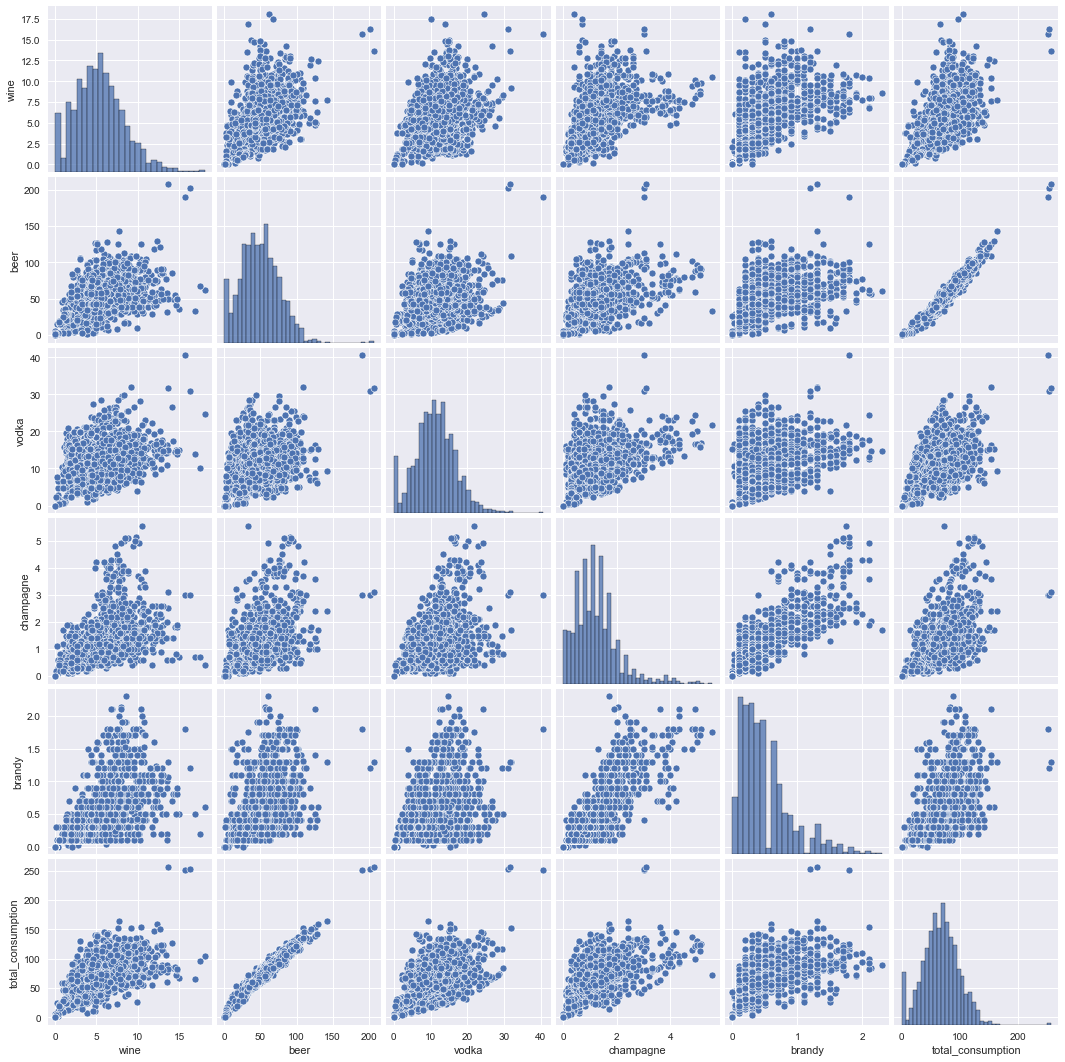

In [19]:
sns.pairplot(data=alcohol_sales_df.iloc[:, 1:])

plt.show()

**Conclusion:**

* `brandy` has the lowest consumption out of all the drinks


* There is a linear relationship between the `beer` and `total_consumption`

## Filtering out Saint Petersburg

As given in the problem statement that the promotion ran by the company in **Saint Petersburg** was successful.

In [20]:
st_petersburg_df = alcohol_sales_df[alcohol_sales_df["region"] == "Saint Petersburg"]

display(st_petersburg_df.head())

,year,region,wine,beer,vodka,champagne,brandy,total_consumption
59,1998,Saint Petersburg,2.7,27.9,12.3,1.2,0.5,44.6
144,1999,Saint Petersburg,2.6,57.4,13.0,1.7,0.6,75.3
229,2000,Saint Petersburg,4.4,68.2,14.7,2.0,0.9,90.2
314,2001,Saint Petersburg,6.2,101.0,15.5,2.4,0.8,125.9
399,2002,Saint Petersburg,6.3,104.6,17.2,2.6,0.9,131.6


### Approach

Since we are trying to find out the other 10 regions that has similar buying behavior like **Saint Petersburg**, will compare the distribution of `total_consumption` for this region with other.


The following tests will be applied on the distributions:

* **Z-test:** A paramteric test that assumes the distribution to be normal


* **KS Test:** A non-paramteric test having no prior assumption for the distribution

## i. Z-test

In [21]:
st_petersburg_mean = st_petersburg_df["total_consumption"].mean()
st_petersburg_std = st_petersburg_df["total_consumption"].std()

st_petersburg_std_err = st_petersburg_std / np.sqrt(19)

In [22]:
exclude_st_petersburg = alcohol_sales_df["region"]!= "Saint Petersburg"

region_mean_std_df = alcohol_sales_df[exclude_st_petersburg].groupby(["region"]).agg({
    "total_consumption": ["mean", "std"]}).reset_index()

region_mean_std_df.columns = ["region", "mean", "std"]

display(region_mean_std_df.head())

,region,mean,std
0,Altai Krai,62.457368,13.904802
1,Altai Republic,52.786316,19.180088
2,Amur Oblast,74.328421,20.032324
3,Arkhangelsk Oblast,75.589474,26.146742
4,Astrakhan Oblast,69.684211,20.542754


In [23]:
z_stats = []

for index, row in region_mean_std_df.iterrows():
    mean = row["mean"]
    std = row["std"]
    
    std_err = std / np.sqrt(19)
    
    final_score = (st_petersburg_mean - mean) / np.sqrt(st_petersburg_std_err**2 + std_err**2)
    
    z_stats.append(final_score)

In [24]:
region_mean_std_df["z_stats"] = z_stats
region_mean_std_df = region_mean_std_df.sort_values(by=["z_stats"]).reset_index(drop=True)

same_distribution_df = region_mean_std_df[region_mean_std_df["z_stats"] < 2]

display(same_distribution_df.head(10))

,region,mean,std,z_stats
0,Moscow,115.736316,21.525771,-0.884569
1,Yamalo-Nenets Autonomous Okrug,102.980526,26.809979,0.347212
2,Tyumen Oblast,99.585789,25.471831,0.671747
3,Zabaykalsky Krai,90.409474,76.935748,0.825999
4,Komi Republic,98.129474,22.280207,0.838809
5,Chelyabinsk Oblast,96.061053,36.427513,0.874554
6,Khanty–Mansi Autonomous Okrug – Yugra,96.548947,25.557775,0.956087
7,Vologda Oblast,95.128421,29.571503,1.037493
8,Sverdlovsk Oblast,94.955263,26.245142,1.096648
9,Khabarovsk Krai,93.472105,30.147524,1.177056


## ii. KS Test

In [25]:
ks_test_dict = {
    "region": [],
    "ks_statistics": [],
    "p_value": []
}

for region in region_mean_std_df["region"]:
    ks_test_result = ks_2samp(data1=st_petersburg_df.total_consumption,
                    data2=alcohol_sales_df.loc[alcohol_sales_df["region"] == region, "total_consumption"])
    
    ks_test_dict["region"].append(region)
    ks_test_dict["ks_statistics"].append(ks_test_result[0])
    ks_test_dict["p_value"].append(ks_test_result[1])

In [26]:
ks_test_df = pd.DataFrame(ks_test_dict)
ks_test_df = ks_test_df.sort_values(by=["p_value"], ascending=False).reset_index(drop=True)

display(ks_test_df.head(10))

,region,ks_statistics,p_value
0,Moscow,0.263158,0.537929
1,Chelyabinsk Oblast,0.263158,0.537929
2,Omsk Oblast,0.263158,0.537929
3,Khabarovsk Krai,0.368421,0.153173
4,Vologda Oblast,0.421053,0.068089
5,Sverdlovsk Oblast,0.421053,0.068089
6,Ivanovo Oblast,0.421053,0.068089
7,Moscow Oblast,0.421053,0.068089
8,Smolensk Oblast,0.421053,0.068089
9,Tyumen Oblast,0.473684,0.026749


### Conclusion

Will go ahead with the outputs generated by the KS test because the sample size is small for every region i.e. 19 and relying on the z-test here will not be fair.

So, the company should run the promotion in the following regions:

| region             |
|:-------------------|
| Moscow             |
| Chelyabinsk Oblast |
| Omsk Oblast        |
| Khabarovsk Krai    |
| Vologda Oblast     |
| Sverdlovsk Oblast  |
| Ivanovo Oblast     |
| Moscow Oblast      |
| Smolensk Oblast    |
| Tyumen Oblast      |